In [20]:
import torch
from torch import nn
import numpy as np
NUM_EPOCHS =200
BATCH_SIZE = 32
USE_CUDA = False

In [21]:
k = 4
n_channel = 7
M = 2 ** k
R = k/n_channel
print ('M:',M,'k:',k,'n:',n_channel)

M: 4 k: 2 n: 2


In [22]:
import torch
from torch.nn import functional as F
from torch.utils.data import DataLoader
from pytorch_lightning.core.lightning import LightningModule
from torch.autograd import Variable

class RTN(LightningModule):

    def __init__(self, hparams):
        super().__init__()
        self.hparams = hparams
        self.EbNodB_range = hparams["EbNodB_range"]
        self.train_num = hparams["train_num"]
        self.test_num = hparams["test_num"]
        self.batch_size = hparams["batch_size"]

        self.in_channels = hparams["in_channels"]
        self.compressed_dim = hparams["compressed_dim"]
        self.training_signal_noise_ratio = 5.01187

        self.encoder = nn.Sequential(
            nn.Linear(self.in_channels, self.in_channels),
            nn.ReLU(inplace=True),
            nn.Linear(self.in_channels, self.compressed_dim)
        )

        self.decoder = nn.Sequential(
            nn.Linear(self.compressed_dim, self.in_channels),
            nn.ReLU(inplace=True),
            nn.Linear(self.in_channels, self.in_channels)
        )

    def decode_signal(self, x):
        return self.decoder(x)
    
    def encode_signal(self,x):
        return self.encoder(x)
    
    def AWGN(self,x,ebno):
        """ Adding Noise for testing step.
        """
         # Normalization.
        x = (self.in_channels **0.5) * (x / x.norm(dim=-1)[:, None])
        # bit / channel_use
        communication_rate = R
        # Simulated Gaussian noise.
        noise = Variable(torch.randn(*x.size()) / ((2 * communication_rate * ebno) ** 0.5))
        x += noise
        return x

    def forward(self, x):
        x = self.encoder(x)
        self.AWGN(x, self.training_signal_noise_ratio)
        x = self.decoder(x)

        return x

    def prepare_data(self):
        train_labels = (torch.rand(self.train_num) * self.in_channels).long()
        train_data = torch.sparse.torch.eye(self.in_channels).index_select(dim=0, index=train_labels)

        test_labels = (torch.rand(self.test_num) * self.in_channels).long()
        test_data = torch.sparse.torch.eye(self.in_channels).index_select(dim=0, index=test_labels)

        self.dataset_train = torch.utils.data.TensorDataset( train_data, train_labels)
        self.dataset_test = torch.utils.data.TensorDataset( test_data, test_labels)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.forward(x)
        loss = F.cross_entropy(y_hat, y)
        tensorboard_logs = {'train_loss': loss}
        return {'loss': loss, 'log': tensorboard_logs}

    def test_step(self, batch, batch_idx):
        x, y = batch

        EbNodB_range = self.EbNodB_range
        ber= [None]*len(EbNodB_range)          
        for n in range(len(EbNodB_range)):
            EbNo=10.0**(EbNodB_range[n]/10.0)

            encoder=model.encode_signal(x)
            encoder=model.AWGN(encoder,EbNo)
            decoder=model.decode_signal(encoder)
            pred=decoder.data.numpy()
            label=y.data.numpy()
            pred_output = np.argmax(pred,axis=1)
            no_errors = (pred_output != label)
            no_errors =  no_errors.astype(int).sum()
            ber[n] = no_errors / self.test_num

        return ber
    
    def test_epoch_end(self, outputs):
        ber_curve = torch.Tensor(outputs).sum(0)
        import matplotlib.pyplot as plt 
        plt.plot(self.EbNodB_range, ber_curve, 'bo',label='Autoencoder({},{})'.format(k, n_channel))
        plt.yscale('log')
        plt.xlabel('SNR Range')
        plt.ylabel('Block Error Rate')
        plt.grid()
        plt.legend(loc='upper right',ncol = 1)
        plt.show()


    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

    def train_dataloader(self): 
        return DataLoader(dataset = self.dataset_train, batch_size = self.batch_size, shuffle = True)

    def test_dataloader(self):
        return DataLoader(dataset =  self.dataset_test, batch_size = self.batch_size, shuffle = True)

In [23]:
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping

hparams = {
    "train_num":int(1e5),
    "test_num":int(1e5),
    "batch_size": 32,
    "in_channels": M,
    "compressed_dim": n_channel,
    "EbNodB_range":  list(range(-5,9)),
}

model = RTN(hparams)



trainer = Trainer(
    max_epochs = 20,
    )
trainer.fit(model)


GPU available: False, used: False
TPU available: False, using: 0 TPU cores

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 30    
1 | decoder | Sequential | 32    
Epoch 20: 100%|██████████| 3125/3125 [00:09<00:00, 344.01it/s, loss=0.000, v_num=23]


1

Testing:  99%|█████████▉| 3109/3125 [00:07<00:00, 420.16it/s]

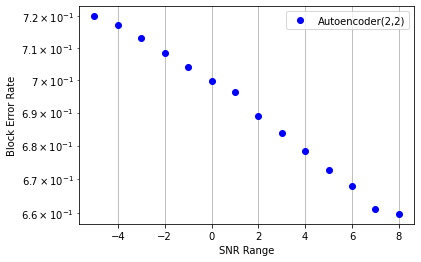

Testing: 100%|██████████| 3125/3125 [00:07<00:00, 394.62it/s]


1

In [24]:
trainer.test()